# Bigram Name Generator

In [1]:
# Download names.txt from github
import requests
from pathlib import Path

# Set up a data folder
data_path = Path("data/")

if data_path.is_dir():
    print(f"{data_path}/ already exists... skipping")
else:
    print(f"{data_path}/ does not exist, creating one...")
    data_path.mkdir(parents=True, exist_ok=True)

    # Download data
    with open(data_path / "names.txt", "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/karpathy/makemore/master/names.txt")
        f.write(request.content)


data/ already exists... skipping


In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Open names.txt and turn it into a list of names with '.' as the start and end character
with open(data_path / "names.txt", "r") as f:
    words = ["."+line.strip()+"." for line in f.readlines()]

# Create bigrams from all the names
bigrams = []
for word in words:
    name_bigram = [(f,s) for f, s in zip(word[:], word[1:])]
    for bigram in name_bigram:
        bigrams.append(bigram)

# Create mappings for char's to int's and vice versa
char_set = {char for word in words for char in word}
ctoi = {c: i for i, c in enumerate(sorted(list(char_set)))}
itoc = {i: c for i, c in enumerate(sorted(list(char_set)))}

# Record the amount of occurances of each char following another char
occurances = torch.ones(len(char_set), len(char_set), dtype=float)
for bigram in bigrams:
    ch1, ch2 = bigram
    ix1, ix2 = ctoi[ch1], ctoi[ch2]
    occurances[ix1][ix2] +=1

device


device(type='cuda')

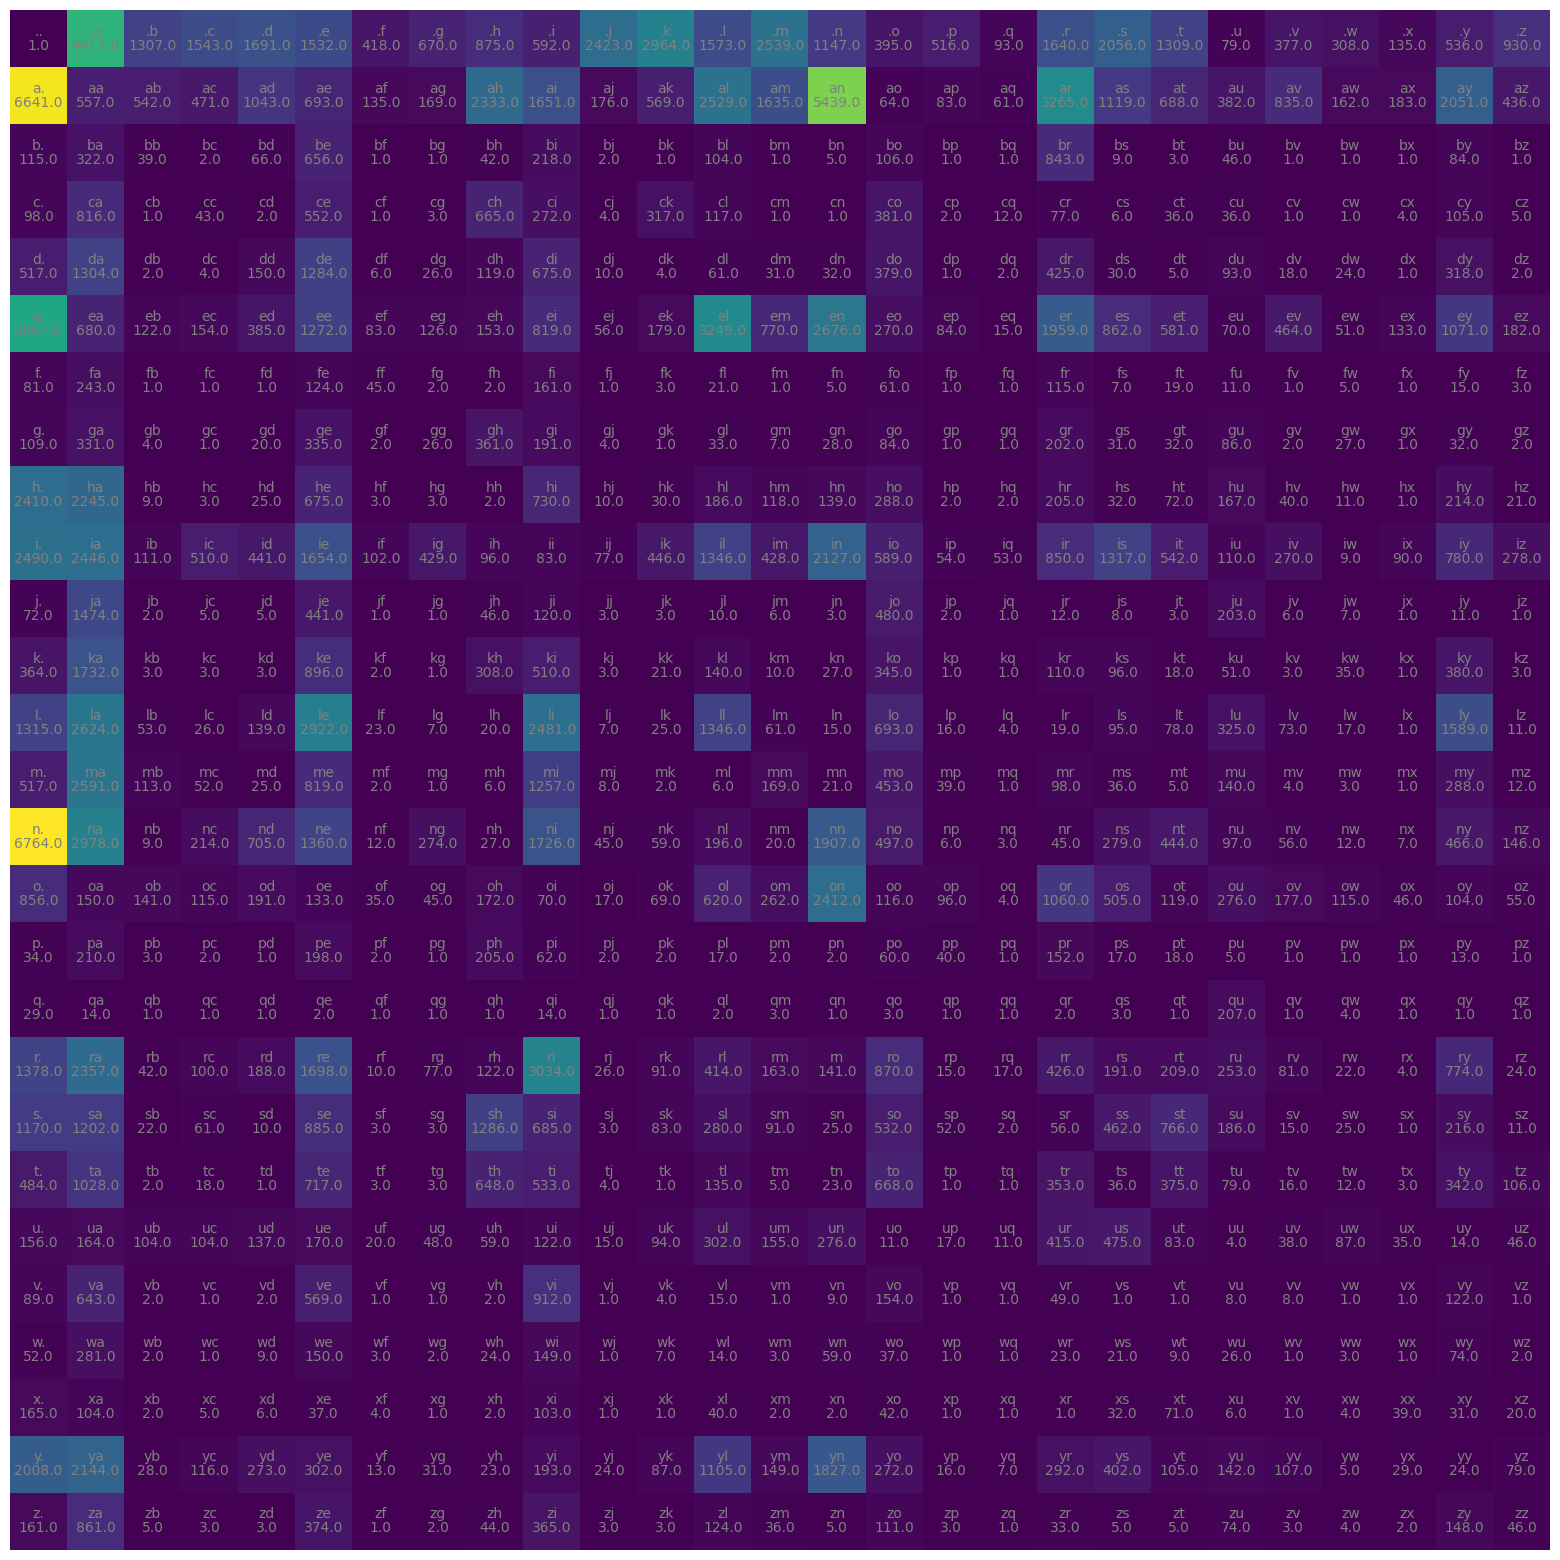

In [3]:
plt.figure(figsize=(20,20))
plt.imshow(occurances)
for i in range(27):
    for j in range(27):
        chstr = itoc[i] + itoc[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, occurances[i,j].item(), ha="center", va="top", color="gray")
plt.axis("off");

In [4]:
# Use torch.multinomial to sample from a row's probability distribution
RAND_SEED = 2697
g = torch.Generator().manual_seed(RAND_SEED)
sums = occurances.sum(dim=1, keepdim=True)
PROBS = occurances/sums
names = []

for _ in range(10):
    idx = 0
    name = ""
    while True:
        idx = torch.multinomial(input=PROBS[idx], num_samples=1, replacement=True, generator=g).item()
        letter = itoc[idx]
        name += letter
        if idx == 0:
            names.append(name)
            break
print(names)
print(PROBS[0][1])
print(occurances[0][1]/sums[0])

['dennd.', 'ke.', 'beyle.', 'ashost.', 'ce.', 'juldade.', 'ckandit.', 'zua.', 'acahletol.', 'pahalllyni.']
tensor(0.1376, dtype=torch.float64)
tensor([0.1376], dtype=torch.float64)


In [5]:
# Finding loss of the model
log_likelihood = 0.0
n = 0

for w in words:
    for ch1, ch2 in zip(w, w[1:]):
        ix1 = ctoi[ch1]
        ix2 = ctoi[ch1]
        prob = PROBS[ix1,ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        #print(f'{ch1}{ch2} : prob {prob:.4f} logprob {logprob:.4f}')
print(f'{log_likelihood=}')
nli = -log_likelihood
print(f'{nli=}')
print(f'{nli/n=}')

log_likelihood=tensor(-1121315.4783, dtype=torch.float64)
nli=tensor(1121315.4783, dtype=torch.float64)
nli/n=tensor(4.9149, dtype=torch.float64)


In [18]:
# Create a training set of all the bigrams (x,y)
xs, ys = [], []

for w in words:
    for ch1, ch2 in zip(w, w[1:]):
        ix1 = ctoi[ch1]
        ix2 = ctoi[ch1]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs, ys

xs = nn.functional.one_hot(xs, num_classes=len(char_set)).float()
ys = nn.functional.one_hot(ys, num_classes=len(char_set)).float()

X_train, X_test, y_train, y_test = xs[:int(len(xs)*.8)], xs[int(len(xs)*.8):], ys[:int(len(xs)*.8)], ys[int(len(xs)*.8):]
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)




In [7]:
# Build simple neural network
from torch import nn
from sklearn.metrics import accuracy_score

SEED = 2697
torch.manual_seed(SEED)
class BigramNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_features=len(char_set), out_features=len(char_set)))

    def forward(self, x):
        return self.net(x)

model = BigramNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(params=model.parameters(),
                          lr=0.001)



In [8]:
def train(model,
          X_train,
          y_train,
          X_test,
          y_test,
          loss_fn,
          optimizer, 
          epoch):
    model.train()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    test_loss, test_acc = 0.0, 0.0
    model.eval()
    with torch.inference_mode():
        pred = model(X_test)
        test_loss = loss_fn(pred, y_test)
        label = y_test.argmax(dim=1)
        prediction = pred.argmax(dim=1)
        test_acc = accuracy_score(label.cpu(), prediction.cpu())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}\nTrain Loss: {loss:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}\nDevice: {device}\n")


In [9]:
epochs = 899
for epoch in range(epochs):
    train(model=model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, loss_fn=loss_fn, optimizer=optim, epoch=epoch)



Epoch 0
Train Loss: 3.3169 | Test Loss: 3.3221, Test Acc: 0.0000
Device: cuda

Epoch 100
Train Loss: 3.0470 | Test Loss: 3.0657, Test Acc: 0.3354
Device: cuda

Epoch 200
Train Loss: 2.7931 | Test Loss: 2.8240, Test Acc: 0.5793
Device: cuda

Epoch 300
Train Loss: 2.5549 | Test Loss: 2.5962, Test Acc: 0.7085
Device: cuda

Epoch 400
Train Loss: 2.3319 | Test Loss: 2.3819, Test Acc: 0.7361
Device: cuda

Epoch 500
Train Loss: 2.1240 | Test Loss: 2.1808, Test Acc: 0.8528
Device: cuda

Epoch 600
Train Loss: 1.9308 | Test Loss: 1.9926, Test Acc: 0.9034
Device: cuda

Epoch 700
Train Loss: 1.7524 | Test Loss: 1.8173, Test Acc: 0.9539
Device: cuda

Epoch 800
Train Loss: 1.5883 | Test Loss: 1.6547, Test Acc: 0.9888
Device: cuda



In [30]:
# Forward pass
g = torch.Generator().manual_seed(SEED)
W = torch.randn((27,27), generator=g, requires_grad=True)
logits = xs[:5] @ W # log counts
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)


In [31]:
loss = -probs[torch.arange(5),ys.argmax(dim=1)[:5]].log().mean()
loss

tensor(3.4197, grad_fn=<NegBackward0>)

In [32]:
W.grad = None
loss.backward()

In [39]:
W.data += -0.1 * W.grad

In [43]:
logits = xs[:5] @ W # log counts
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(5),ys.argmax(dim=1)[:5]].log().mean()
loss

tensor(3.3941, grad_fn=<NegBackward0>)